# Validating Cluster Model Performance

#### Install and import packages


In [1]:
#Imports

# multiprocessing
from joblib import Parallel, delayed

# data manipulation
import numpy as np
import pandas as pd
import heapq

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

#hmm needed? 
import torch
import torch.nn as nn
#from torch import nn
import torch.optim as optim
import shutil
import sklearn
from sklearn.preprocessing import MinMaxScaler
#from tqdm import tqdm_notebook as tqdm

#darts
# transformers and preprocessing
import darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import * #everything

#loss metrics
from darts.metrics import mape
from darts.metrics import smape
from darts.utils.losses import SmapeLoss

# likelihood
from darts.utils.likelihood_models import GaussianLikelihood

# settings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


#extras
import os
import time
import random
from datetime import datetime
from itertools import product
from typing import List, Tuple, Dict
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge
import glob

In [3]:
cl1 = pd.read_csv('/work/Data-Science-Liv/Data/holt_cluster_forecasts/holt_forecasts_cluster0.csv', parse_dates=['ds'])
cl2 = pd.read_csv('/work/Data-Science-Liv/Data/holt_cluster_forecasts/holt_forecasts_cluster1.csv', parse_dates=['ds'])
cl3 = pd.read_csv('/work/Data-Science-Liv/Data/holt_cluster_forecasts/holt_forecasts_cluster2.csv', parse_dates=['ds'])
cl4 = pd.read_csv('/work/Data-Science-Liv/Data/holt_cluster_forecasts/holt_forecasts_cluster3.csv', parse_dates=['ds'])


#### Data inspection
- Removing NA rows from years included in the training set
- Making sure the year span is correct
- Checking the unique countries in each cluster

In [4]:
#Remove rows with NAs - these rows represent the first years in the data that were used for training. Here we only have the test forecasts
cl1 = cl1.dropna(subset=['final_prediction'])
cl2 = cl2.dropna(subset=['final_prediction'])
cl3 = cl3.dropna(subset=['final_prediction'])
cl4 = cl4.dropna(subset=['final_prediction'])

In [5]:
#Are there any NAs in the dfs now?
data_frames = [cl1, cl2, cl3, cl4]

# Check if any of the data frames contain NAs
for df in data_frames:
    if df.isna().any().any():
        print(f"At least one NA value found in DataFrame {df}.")
        break
else:
    print("No NA values found in any of the data frames.")

# There are no NAs in the dfs now


No NA values found in any of the data frames.


In [6]:
# Are there overlapping countries in the data frames?
data_frames = [cl1, cl2, cl3, cl4]
common_countries = set()

# Compare unique countries pairwise between data frames
for i in range(len(data_frames)):
    for j in range(i+1, len(data_frames)):
        countries_i = set(data_frames[i]['Country'].unique())
        countries_j = set(data_frames[j]['Country'].unique())
        
        if countries_i & countries_j:  # Check if there are common countries
            common_countries.update(countries_i & countries_j)

# Check if there are any common countries among the data frames
if common_countries:
    print("At least two data frames have common countries.")
else:
    print("No common countries found among the data frames.")


#The clusters do not contain the same countries

No common countries found among the data frames.


In [7]:
# # Checking the years over which the data span and if they are the same
data_frames = [cl1, cl2, cl3, cl4]

unique_years = [set(df['ds'].dt.year.unique()) for df in data_frames]
same_unique_years = all(years == unique_years[0] for years in unique_years)

min_dates = [df['ds'].min() for df in data_frames]
max_dates = [df['ds'].max() for df in data_frames]
same_time_range = all(date == min_dates[0] for date in min_dates) and all(date == max_dates[0] for date in max_dates)

time_range = f"{min_dates[0]} - {max_dates[0]}"

print("Same unique years:", same_unique_years)
print("Time range:", time_range)




Same unique years: True
Time range: 2012-01-01 00:00:00 - 2021-01-01 00:00:00


### This is where the validation goes down
- sMAPE

Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors.
It is a metric used to evaluate the accuracy of a forecasting model or compare the performance of different forecasting models.

#### Calculating sMAPES per country

In [8]:
data_frames = [cl1, cl2, cl3, cl4]

#Initialise empty lists to store the sMAPE values per country, and their names to use when creating  the final output
smape_values_per_dataset = []
country_names_per_dataset = []

for data_set in data_frames:
    smape_values_per_country = []
    country_names = []

    for country in data_set['Country'].unique():
        country_data = data_set[data_set['Country'] == country]
        forecast_series = TimeSeries.from_dataframe(country_data, time_col='ds', value_cols='final_prediction')
        actual_series = TimeSeries.from_dataframe(country_data, time_col='ds', value_cols='y_tst')
        sMAPE_value = smape(forecast_series, actual_series)
        smape_values_per_country.append(sMAPE_value)
        country_names.append(country)

    # Sort the country names and sMAPE values based on sMAPE values in ascending order
    sorted_data = sorted(zip(country_names, smape_values_per_country), key=lambda x: x[1])

    # Unzip the sorted data to separate country names and sMAPE values
    sorted_country_names, sorted_smape_values = zip(*sorted_data)

    smape_values_per_dataset.append(sorted_smape_values)
    country_names_per_dataset.append(sorted_country_names)

# Create a new dataframe to store the results
sMAPES_df = pd.DataFrame()

for i, smape_values in enumerate(smape_values_per_dataset):
    cluster_name = f"Cluster {i+1}"
    cluster_countries = country_names_per_dataset[i]

    # Create a temporary dataframe to store the cluster's results
    temp_df = pd.DataFrame({'Country': cluster_countries, 'sMAPE': smape_values, 'Cluster': cluster_name})

    # Append the temporary dataframe to the output dataframe
    sMAPES_df = sMAPES_df.append(temp_df, ignore_index=True)


In [9]:
# Save the sMAPE data frame to csv
file_path = '/work/Data-Science-Liv/Data/Holt_sMAPES_df.csv'
sMAPES_df.to_csv(file_path, index=False)

### Quantify general performance of the cluster modelling approach
- Mean sMAPE across ll countries
- Median sMAPE across all countries
- Weighted sMAPE - accounting for the different number of countries in each cluster. Clusters with more countries are given more importance

In [10]:
# Calculate overall Mean sMAPE
mean_smape = np.mean(sMAPES_df['sMAPE'])
print("Mean sMAPE:", mean_smape)

# Calculate Median sMAPE
median_smape = np.median(sMAPES_df['sMAPE'])
print("Median sMAPE:", median_smape)

# # Calculate Weighted sMAPE - doesn't work very well rn, maybe because of some extreme sMAPE values for some countries
# weights = sMAPES_df.groupby('Cluster')['Country'].transform('count') / len(sMAPES_df)
# weighted_smape = np.sum(sMAPES_df['sMAPE'] * weights)
# print("Weighted sMAPE:", weighted_smape)

Mean sMAPE: 4.625609497662408
Median sMAPE: 2.9781210454526224


#### Visualise

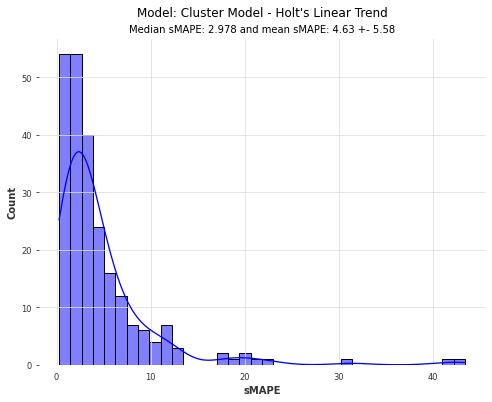

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram plot of sMAPE values
plt.figure(figsize=(8, 6))
sns.histplot(data=sMAPES_df, x='sMAPE', kde=True, color='blue')

# Set plot labels and title
plt.xlabel('sMAPE')
plt.ylabel('Count')

# Add model name and statistics as title and subtitle
name = "Cluster Model - Holt's Linear Trend"  # Replace "Your Model" with your actual model name
smapes = sMAPES_df['sMAPE']  # Assuming sMAPES_df contains the sMAPE values
subtitle = "Median sMAPE: {:.3f} and mean sMAPE: {:.2f} +- {:.2f}".format(np.median(smapes), np.mean(smapes), np.std(smapes))
plt.title("Model: {}".format(name), y=1.05)
plt.text(0.5, 1.03, subtitle, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

# Show the plot
plt.show()


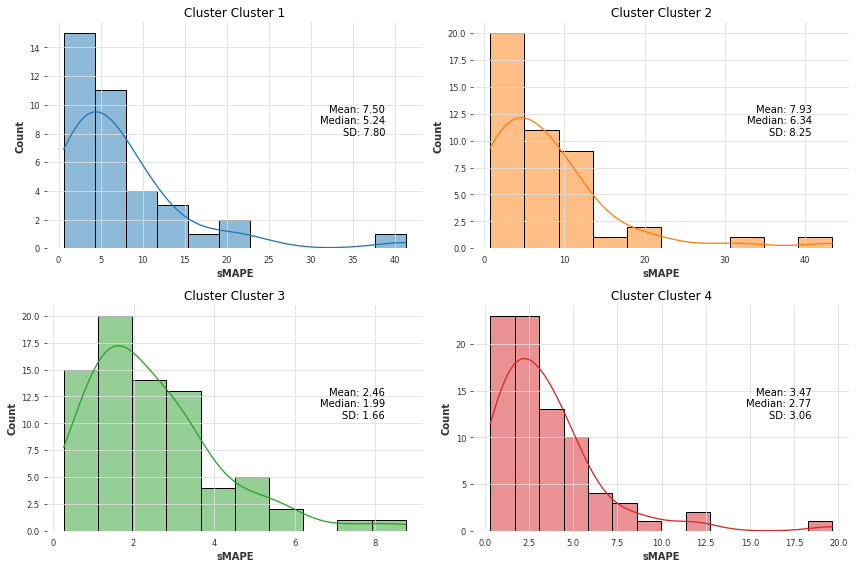

In [14]:
# Create a histogram plot for each cluster
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Define a color palette with a color for each cluster
color_palette = sns.color_palette('tab10', len(sMAPES_df['Cluster'].unique()))

for i, (cluster_name, countries) in enumerate(sMAPES_df.groupby('Cluster')):
    # Extract the sMAPE values for the current cluster
    cluster_smape_values = countries['sMAPE']

    # Plot the distribution of sMAPE values for the current cluster
    ax = sns.histplot(cluster_smape_values, ax=axes[i], kde=True, color=color_palette[i])
    ax.set_title(f"Cluster {cluster_name}")
    ax.set_xlabel('sMAPE')

    # Calculate and annotate the mean, median, and standard deviation of sMAPE values
    mean_smape = cluster_smape_values.mean()
    median_smape = cluster_smape_values.median()
    std_smape = cluster_smape_values.std()
    ax.text(0.9, 0.5, f"Mean: {mean_smape:.2f}\nMedian: {median_smape:.2f}\nSD: {std_smape:.2f}",
            transform=ax.transAxes, fontsize=10, ha='right')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### Extract the countries with the highest sMAPE values

#### Overall

In [15]:
# In total - shows that these are all in cluser 1 and 2
# Sort the DataFrame by sMAPE values in descending order
sorted_df = sMAPES_df.sort_values('sMAPE', ascending=False)

# Extract the top 5 countries and their sMAPE values
top_countries = sorted_df.head(5)[['Country', 'sMAPE', 'Cluster']]

# Display the top 5 countries and their sMAPE values
print(top_countries)


     Country      sMAPE    Cluster
81  Eswatini  43.401397  Cluster 2
36  Zimbabwe  41.322860  Cluster 1
80   Lesotho  31.397592  Cluster 2
35  Botswana  22.813827  Cluster 1
79    Zambia  21.726153  Cluster 2


#### In cluster 3 and 4

In [16]:
# In cluyster 3 and 4
# Filter the DataFrame to include only cluster 3 and 4
filtered_df = sMAPES_df[sMAPES_df['Cluster'].isin([3, 4])]

# Sort the DataFrame by sMAPE values in descending order
sorted_df = filtered_df.sort_values('sMAPE', ascending=False)

# Select the top 5 countries with the highest sMAPE values
top_countries = sorted_df.head(5)

# Display the top 5 countries
print(top_countries[['Country', 'sMAPE','Cluster']])


Empty DataFrame
Columns: [Country, sMAPE, Cluster]
Index: []


#### Minimum and maximum per cluster

In [17]:
# Min and max per cluster
# Group the DataFrame by 'Cluster' and calculate the minimum and maximum sMAPE values
min_smape_per_cluster = sMAPES_df.groupby('Cluster')['sMAPE'].min()
max_smape_per_cluster = sMAPES_df.groupby('Cluster')['sMAPE'].max()

# Display the minimum and maximum sMAPE values per cluster
print("Minimum sMAPE per cluster:")
print(min_smape_per_cluster)
print()
print("Maximum sMAPE per cluster:")
print(max_smape_per_cluster)


Minimum sMAPE per cluster:
Cluster
Cluster 1    0.629244
Cluster 2    0.760094
Cluster 3    0.271718
Cluster 4    0.306948
Name: sMAPE, dtype: float64

Maximum sMAPE per cluster:
Cluster
Cluster 1    41.322860
Cluster 2    43.401397
Cluster 3     8.750046
Cluster 4    19.652722
Name: sMAPE, dtype: float64


#### Overall best performance (lowest sMAPE)

In [18]:
# In total - shows that these are all in cluser 1 and 2
# Sort the DataFrame by sMAPE values in descending order
sorted_df = sMAPES_df.sort_values('sMAPE', ascending=True)

# Extract the top 5 countries and their sMAPE values
top_countries = sorted_df.head(5)[['Country', 'sMAPE', 'Cluster']]

# Display the top 5 countries and their sMAPE values
print(top_countries)

      Country     sMAPE    Cluster
82     Cyprus  0.271718  Cluster 3
157  Thailand  0.306948  Cluster 4
83      Spain  0.314673  Cluster 3
84      Japan  0.355997  Cluster 3
85    Denmark  0.357178  Cluster 3


#### Now doing it for cluster 1 and 2

In [19]:
# In cluyster 3 and 4
# Filter the DataFrame to include only cluster 3 and 4
filtered_df = sMAPES_df[sMAPES_df['Cluster'].isin([1, 2])]

# Sort the DataFrame by sMAPE values in descending order
sorted_df = filtered_df.sort_values('sMAPE', ascending=True)

# Select the top 5 countries with the highest sMAPE values
top_countries = sorted_df.head(5)

# Display the top 5 countries
print(top_countries[['Country', 'sMAPE','Cluster']])

Empty DataFrame
Columns: [Country, sMAPE, Cluster]
Index: []
